In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import stats
import math
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image, display
from matplotlib.colors import ListedColormap
import os
import struct

In [3]:
def load_mnist(path, kind = 'train'):
    #Load MNIST data from 'path'
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    #The with statement gurantees that the file will be closed no matter how the nested block exits
    #Open arguments: 'rb' -> r=reading b=binary file mode
    #Refer to the opened file as libpath
    with open(labels_path, 'rb') as libpath:
        #(>) big-endian and II refers to 2 usigned integers of 4 bytes each
        #we read in 8 bytes and stores them as the magic number and the number of items
        #See the MNIST website for the data description
        magic, n = struct.unpack('>II',libpath.read(8))
        #fromfile is a function in the numpy package
        #A highly efficient way of reading binary data with a known data-type, 
        #as well as parsing simply formatted text files. 
        #Since count was not supplied it will read in all values
        labels = np.fromfile(libpath, dtype = np.uint8)
        #similar but reading in 4 unsigned integers to start
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
        #the reshape option transforms the array into the correct type of matrix
        #nx784-- note the tru data is a 28x28 image
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(num,rows*cols)
    print('Observations labels: %d, Observations Images: %d' % (n,num))
    return images, labels

In [4]:
def print_mnist(images,labels,seed = 123):
    obs= np.arange(10)
    fig,ax = plt.subplots(nrows = 2, ncols = 5,sharex = True, sharey = True)
    ax = ax.flatten()
    for i in obs:
        imgs = images[labels == i,:]
        n = imgs.shape[0]
        index = np.random.choice(np.arange(n),size=1,replace = False)
        img = imgs[index,:].reshape(28,28)
        xlabel = "{}".format(labels_dict[i])
        ax[i].imshow(img, cmap = 'Greys')   
        ax[i].set_xlabel(xlabel)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    plt.close()
    return

def plot_error(images, labels_true, labels_pred):
    fig, axes = plt.subplots(3, 2)
    p = np.not_equal(labels_true,labels_pred)
    err = p[p==True].shape[0]/p.shape[0]
    acc = 1 - err
    print("Total miss-classified: {} out of: {}\nMiss-classification error: {:0.2f}%\nAccuracy :{:0.2f}%".format(p[p==True].shape[0],p.shape[0],100*err,100*acc))
    images = images[p,:]
    labels_true = labels_true[p]
    labels_pred = labels_pred[p]
    for i, ax in enumerate(axes.flat):
        if i< p[p==True].shape[0]:
            ax.imshow(images[i].reshape((28,28)), cmap='gray')
            xlabel = "(True: {0}, Predicted: {1})".format(labels_dict[labels_true[i]], labels_dict[labels_pred[i]])

            ax.set_xlabel(xlabel)
            ax.set_xticks([])
            ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
def accuracy(ConfusionMatrix):
    CF = np.copy(ConfusionMatrix.as_matrix())
    TP = np.sum(np.diagonal(CF))
    np.fill_diagonal(CF,0)
    FP =np.sum(CF)
    return TP/(TP+FP)   

#Precision measures the accuracy of the positive predictions
def Precision(ConfusionMatrix):
    CF = np.copy(ConfusionMatrix.as_matrix())
    TP = np.diagonal(ConfusionMatrix)
    np.fill_diagonal(CF,0)
    FP =np.sum(CF,axis=0)
    return TP/(TP+FP)

#Recall(sensitivity, True Positive Rate)
def Recall(ConfusionMatrix):
    CF = np.copy(ConfusionMatrix.as_matrix())
    TP = np.diagonal(ConfusionMatrix)
    np.fill_diagonal(CF,0)
    FN =np.sum(CF,axis=1)
    return TP/(TP+FN)

def F1_Score(ConfusionMatrix):
    precision = Precision(ConfusionMatrix)
    recall = Recall(ConfusionMatrix)
    F1 = 2*(precision*recall)/(precision+recall)
    return F1

def confusionMatrix(pred_labels,actual_labels,label_dict):
    labels = [labels_dict[i] for i in label_dict.keys()]
    M = actual_labels.shape[0]
    tmp = np.array([np.arange(M,dtype =np.int32)+1,pred_labels,actual_labels]).T
    result = pd.DataFrame(data = tmp, columns=['ImageId', 'Predicted_Label','Actual_Label'])
    n = 10
    conf = np.zeros([n,n],dtype = np.int32)
    for i in range(n):
        for j in range(n):
            conf[i,j] = np.sum(result[result["Actual_Label"] == i]["Predicted_Label"] == j)
    confusion = pd.DataFrame(conf,index=labels,columns=labels)
    pd.Series.__unicode__ = pd.Series.to_string
    err = np.sum(confusion.T)-np.diag(confusion)
    precision = pd.DataFrame(Precision(confusion), columns=['Precision'],index=labels)
    recall = pd.DataFrame(Recall(confusion), columns=['Recall'],index=labels)
    F1 = pd.DataFrame(F1_Score(confusion), columns=['F1'],index=labels)
    confusion = pd.concat([confusion,precision,recall,F1],axis=1)
    return confusion

In [6]:
mnist_loc = "../Data"

In [7]:
X_train, Y_train = load_mnist(mnist_loc,kind = "train")
shuffle_ind = np.random.permutation(X_train.shape[0])
X_train, Y_train = X_train[shuffle_ind,:], Y_train[shuffle_ind]

Observations labels: 60000, Observations Images: 60000


In [8]:
X_test, Y_test = load_mnist(mnist_loc,kind = "t10k")

Observations labels: 10000, Observations Images: 10000


In [9]:
labels_dict = {0:'Zero'
,1:'One'
,2:'Two'
,3:'Three'
,4:'Four'
,5:'Five'
,6:'Six'
,7:'Seven'
,8:'Eight'
,9:'Nine'}

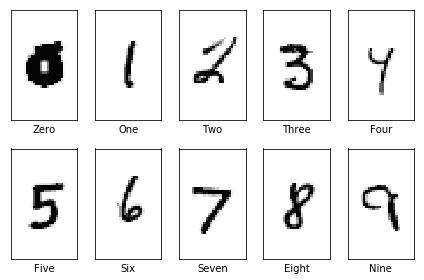

In [10]:
print_mnist(X_train, Y_train)

## Bagged estimator using decision trees

First fit a standard decision tree of may_depth 8

Then compare a bagged estimator of $B=25$ decision trees of the same depth

In [11]:
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, random_state =123)
tree.fit(X_train,Y_train)
pred = tree.predict(X_train)
print("Training Accuracy: {:.2f}%".format(100*np.sum(pred==Y_train)/Y_train.shape[0]))

Training Accuracy: 82.63%


In [13]:
pred = tree.predict(X_test)
dt_pred = pred
print("Testing Accuracy: {:.2f}%".format(100*np.sum(pred==Y_test)/Y_test.shape[0]))

Testing Accuracy: 81.80%


In [12]:
def resample_index(n):
    index = np.random.choice(n,size = n,replace = True)
    return index
def complement_index(n,index):
    comp = list(set(range(n))-set(index))
    return comp

In [14]:
B = 100
trees = []
preds_train = []
preds_test = []
for b in range(B):
    index = resample_index(X_train.shape[0])
    tmp_X = X_train[index,:]
    tmp_Y = Y_train[index]
    print("Fitting tree: {}".format(b+1))
    tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, random_state =123)
    trees.append(tree.fit(tmp_X,tmp_Y))
    pred = tree.predict(X_train)
    preds_train.append(pred)
    print("Training Accuracy: {:.2f}%".format(100*np.sum(pred==Y_train)/Y_train.shape[0]))
    pred = tree.predict(X_test)
    preds_test.append(pred)
    print("Testing Accuracy: {:.2f}%".format(100*np.sum(pred==Y_test)/Y_test.shape[0]))

Fitting tree: 1
Training Accuracy: 82.37%
Testing Accuracy: 81.82%
Fitting tree: 2
Training Accuracy: 82.50%
Testing Accuracy: 81.94%
Fitting tree: 3
Training Accuracy: 83.36%
Testing Accuracy: 82.03%
Fitting tree: 4
Training Accuracy: 82.52%
Testing Accuracy: 81.49%
Fitting tree: 5
Training Accuracy: 81.86%
Testing Accuracy: 80.87%
Fitting tree: 6
Training Accuracy: 82.23%
Testing Accuracy: 81.77%
Fitting tree: 7
Training Accuracy: 82.49%
Testing Accuracy: 81.25%
Fitting tree: 8
Training Accuracy: 82.45%
Testing Accuracy: 82.08%
Fitting tree: 9
Training Accuracy: 82.64%
Testing Accuracy: 82.62%
Fitting tree: 10
Training Accuracy: 82.61%
Testing Accuracy: 81.81%
Fitting tree: 11
Training Accuracy: 82.23%
Testing Accuracy: 81.50%
Fitting tree: 12
Training Accuracy: 82.61%
Testing Accuracy: 82.28%
Fitting tree: 13
Training Accuracy: 81.37%
Testing Accuracy: 79.82%
Fitting tree: 14
Training Accuracy: 82.39%
Testing Accuracy: 81.72%
Fitting tree: 15
Training Accuracy: 82.11%
Testing Accura

In [15]:
from scipy import stats
preds_train = np.array(preds_train).T
preds_test= np.array(preds_test).T

ensemble_train,_ = stats.mode(preds_train,axis = 1)
ensemble_train = ensemble_train.flatten()
ensemble_test,_ = stats.mode(preds_test,axis = 1)
ensemble_test = ensemble_test.flatten()

In [16]:
print("Training Accuracy: {:.2f}%".format(100*np.sum(ensemble_train==Y_train)/Y_train.shape[0]))
print("Testing Accuracy: {:.2f}%".format(100*np.sum(ensemble_test==Y_test)/Y_test.shape[0]))

Training Accuracy: 89.56%
Testing Accuracy: 88.83%


In [17]:
#Decision tree confusion matrix
cm = confusionMatrix(pred_labels = dt_pred ,actual_labels = Y_test,label_dict = labels_dict)
cm

,Zero,One,Two,Three,Four,Five,Six,Seven,Eight,Nine,Precision,Recall,F1
Zero,904,0,5,11,3,11,25,4,8,9,0.885406,0.922449,0.903548
One,0,1075,7,19,3,10,4,6,10,1,0.866935,0.947137,0.905263
Two,22,33,819,9,24,17,35,21,30,22,0.862105,0.793605,0.826438
Three,7,12,41,771,5,89,16,11,26,32,0.813291,0.763366,0.787538
Four,4,25,2,3,772,22,32,6,22,94,0.834595,0.786151,0.809649
Five,22,11,5,69,19,682,23,11,26,24,0.695918,0.764574,0.728632
Six,26,11,12,9,32,34,808,1,14,11,0.801587,0.843424,0.821974
Seven,2,38,32,9,11,8,3,837,13,75,0.898069,0.814202,0.854082
Eight,20,26,24,24,18,74,50,14,680,44,0.798122,0.698152,0.744797
Nine,14,9,3,24,38,33,12,21,23,832,0.727273,0.824579,0.772875


In [18]:
#Ensemble confusion matrix
cm_ensemble = confusionMatrix(pred_labels = ensemble_test ,actual_labels = Y_test,label_dict = labels_dict)
cm_ensemble

,Zero,One,Two,Three,Four,Five,Six,Seven,Eight,Nine,Precision,Recall,F1
Zero,946,1,3,3,3,7,5,4,6,2,0.933860,0.965306,0.949323
One,0,1107,7,7,0,2,4,2,6,0,0.955134,0.975330,0.965126
Two,11,6,923,14,16,4,11,15,16,16,0.884100,0.894380,0.889210
Three,6,1,36,845,1,45,10,10,38,18,0.890411,0.836634,0.862685
Four,3,5,6,2,823,6,14,5,23,95,0.884946,0.838086,0.860879
Five,10,6,2,38,16,765,20,6,15,14,0.863431,0.857623,0.860517
Six,19,6,5,2,15,27,870,1,13,0,0.909091,0.908142,0.908616
Seven,1,17,29,8,8,4,0,885,9,67,0.936508,0.860895,0.897111
Eight,8,4,29,15,12,17,18,5,831,35,0.846232,0.853183,0.849693
Nine,9,6,4,15,36,9,5,12,25,888,0.782379,0.880079,0.828358


## Random Forest Example

In [19]:
def OOB(X,Y,trees,notused,features):
    sample = np.random.choice(X.shape[0],size = 2000,replace = False)
    X = X[sample,:]
    n= X.shape[0]
    avg_i = []
    m = len(trees)
    for i in range(n):
        x = X[i,:].reshape(1,X.shape[1])
        count = 0
        total = 0
        for j in range(m):
            unused = notused[j]
            xj = x[:,features[j]]
            if i in unused:
                tree = trees[j]
                pred = tree.predict(xj)
                if(pred == Y[i]):
                    count = count + 1
                total = total +1
        if total != 0:
            avg_i.append(count/total)
    err = 1-np.sum(avg_i)/n
    return(err)

In [20]:
B = 100
trees = []
preds_train = []
preds_test = []
feature_index = []
unused_index = []
n = X_train.shape[0]
p = X_train.shape[1]
m = math.floor(math.sqrt(p))
for b in range(B):
    index = resample_index(n)
    unused = complement_index(n,index)
    unused_index.append(unused)
    features = np.random.choice(p,size = m,replace = False)
    feature_index.append(features)
    tmp_X = X_train[index,:][:,features]
    tmp_Y = Y_train[index]
    tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 8, random_state =123)
    trees.append(tree.fit(tmp_X,tmp_Y))
    pred = tree.predict(X_train[:,features])
    preds_train.append(pred)
    pred = tree.predict(X_test[:,features])
    preds_test.append(pred)
    if b != 0 and b % 20 == 0:
        print("Determining OOB Approximate err at itteration: {}.".format(b))
        oob = OOB(X_train,Y_train,trees,unused_index,feature_index)
        print("OOB Error: {:.2f}%".format(100*oob))

Determining OOB Approximate err at itteration: 20.
OOB Error: 91.01%
Determining OOB Approximate err at itteration: 40.
OOB Error: 89.60%
Determining OOB Approximate err at itteration: 60.
OOB Error: 89.47%
Determining OOB Approximate err at itteration: 80.
OOB Error: 90.09%


In [21]:
preds_train = np.array(preds_train).T
ensemble_train,_ = stats.mode(preds_train,axis = 1)
ensemble_train = ensemble_train.flatten()

preds_test = np.array(preds_test).T
ensemble_test,_ = stats.mode(preds_test,axis = 1)
ensemble_test = ensemble_test.flatten()

In [22]:
print("Training Accuracy: {:.2f}%".format(100*np.sum(ensemble_train==Y_train)/Y_train.shape[0]))
print("Testing Accuracy: {:.2f}%".format(100*np.sum(ensemble_test==Y_test)/Y_test.shape[0]))

Training Accuracy: 91.72%
Testing Accuracy: 91.57%


In [23]:
cm_ensemble = confusionMatrix(pred_labels = ensemble_test ,actual_labels = Y_test,label_dict = labels_dict)
cm_ensemble

,Zero,One,Two,Three,Four,Five,Six,Seven,Eight,Nine,Precision,Recall,F1
Zero,954,0,0,2,0,2,9,1,11,1,0.929825,0.973469,0.951147
One,0,1124,4,2,0,0,3,0,2,0,0.911598,0.990308,0.949324
Two,16,9,927,15,11,0,11,22,19,2,0.941117,0.898256,0.919187
Three,5,8,18,930,0,5,4,12,21,7,0.861909,0.920792,0.890378
Four,0,15,4,0,872,1,18,5,3,64,0.933619,0.887984,0.910230
Five,14,12,3,73,10,728,23,4,14,11,0.970667,0.816143,0.886724
Six,11,5,1,0,6,3,930,1,1,0,0.921705,0.970772,0.945602
Seven,2,30,20,2,7,0,0,933,5,29,0.925595,0.907588,0.916503
Eight,12,18,6,46,6,10,9,11,838,18,0.907909,0.860370,0.883500
Nine,12,12,2,9,22,1,2,19,9,921,0.874644,0.912785,0.893307


## Scikit-learn implementation of random forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion = 'gini',max_depth =8,max_features= m,n_estimators = 100, random_state = 123)
forest.fit(X_train,Y_train)
trainForest = forest.predict(X_train)
testForest = forest.predict(X_test)
print("Training Accuracy: {:.2f}%".format(100*np.sum(trainForest==Y_train)/Y_train.shape[0]))
print("Testing Accuracy: {:.2f}%".format(100*np.sum(testForest==Y_test)/Y_test.shape[0]))

Training Accuracy: 93.30%
Testing Accuracy: 93.05%


In [26]:
cm_ensemble = confusionMatrix(pred_labels = testForest ,actual_labels = Y_test,label_dict = labels_dict)
cm_ensemble

,Zero,One,Two,Three,Four,Five,Six,Seven,Eight,Nine,Precision,Recall,F1
Zero,965,0,0,0,0,3,5,1,5,1,0.951677,0.984694,0.967904
One,0,1119,4,3,0,1,3,1,4,0,0.962995,0.985903,0.974314
Two,8,3,947,12,13,1,12,18,13,5,0.938553,0.917636,0.927976
Three,6,0,17,927,2,17,0,14,18,9,0.917822,0.917822,0.917822
Four,3,3,2,0,886,1,11,2,10,64,0.932632,0.902240,0.917184
Five,7,11,0,32,9,792,14,4,12,11,0.946237,0.887892,0.916136
Six,13,4,0,0,8,8,922,0,3,0,0.942740,0.962422,0.952479
Seven,2,10,29,3,4,0,0,936,5,39,0.947368,0.910506,0.928571
Eight,4,5,8,20,8,9,10,4,879,27,0.911826,0.902464,0.907121
Nine,6,7,2,13,20,5,1,8,15,932,0.856618,0.923687,0.888889


## Boosting-- Gradient Boost

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
#ada =  AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion = 'gini', max_depth = 3),n_estimators = 20, random_state = 123)
GBC = GradientBoostingClassifier(max_depth = 4,n_estimators = 100, random_state = 123)
GBC.fit(X_train,Y_train)
trainGBC= GBC.predict(X_train)
testGBC= GBC.predict(X_test)
print("Training Accuracy: {:.2f}%".format(100*np.sum(trainGBC==Y_train)/Y_train.shape[0]))
print("Testing Accuracy: {:.2f}%".format(100*np.sum(testGBC==Y_test)/Y_test.shape[0]))

Training Accuracy: 98.39%
Testing Accuracy: 96.12%


In [29]:
cm_ensemble = confusionMatrix(pred_labels = testGBC ,actual_labels = Y_test,label_dict = labels_dict)
cm_ensemble

,Zero,One,Two,Three,Four,Five,Six,Seven,Eight,Nine,Precision,Recall,F1
Zero,967,0,0,0,0,3,4,1,4,1,0.971859,0.986735,0.979241
One,0,1121,2,1,1,1,4,0,5,0,0.980752,0.987665,0.984197
Two,5,1,983,10,8,0,2,11,11,1,0.958090,0.952519,0.955296
Three,1,0,8,969,0,7,0,9,12,4,0.950000,0.959406,0.954680
Four,1,1,5,0,947,0,3,0,3,22,0.963377,0.964358,0.963868
Five,4,2,1,12,1,851,9,3,5,4,0.960497,0.954036,0.957255
Six,6,2,1,0,5,13,927,0,4,0,0.975789,0.967641,0.971698
Seven,1,7,22,7,3,2,0,962,4,20,0.966834,0.935798,0.951063
Eight,4,1,2,8,4,5,1,2,937,10,0.944556,0.962012,0.953204
Nine,6,8,2,13,14,4,0,7,7,948,0.938614,0.939544,0.939079
